In [13]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import math
# from util import findCentroid, rotateImage, halveTheRegionHorizontally, computeAsymmetry

import numpy as np
from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing
import random
from noise import pnoise2
from PIL import ImageOps

# ENV
import os

# ISIC API
import requests
import glob

# Main data structure(s)
import pandas as pd
import numpy as np

# For pi value
import math

# For API calls
import time
import json

# Building a data set
import shutil
import zipfile
from io import BytesIO

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data normalization
from sklearn import preprocessing

# Feature extraction
from skimage import morphology
from skimage.transform import rotate
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

# Color 'brightness' (value) spread
from skimage.segmentation import slic # Segments image using k-means clustering in Color-(x,y,z) space
from skimage.measure import regionprops
from skimage.color import rgb2hsv # Converts RGB color to HSV (Hue, Saturation, Value)

# Proper split of training and test data
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

# Model building
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

C:\Users\jackh\AppData\Local\Temp\ipykernel_6224\1187485378.py:52: DeprecationWarning: Please use `mode` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import mode


Find # of data entries for Melanoma and Seborrheic keratosis

In [14]:
import csv

filename = '../data/metadata.csv'
label_counts = {'MEL': 0, 'SEK': 0}

with open(filename, 'r') as csvfile:
    csvreader = csv.reader(csvfile)

    # Skip the header row
    next(csvreader)

    # Loop over each row in the CSV file
    for row in csvreader:
        # Get the label in column 18
        label = row[17]

        # If the label is 'MEL' or 'SEK', increment the corresponding count
        if label in label_counts:
            label_counts[label] += 1

print('Number of MEL labels:', label_counts['MEL'])
print('Number of SEK labels:', label_counts['SEK'])

Number of MEL labels: 52
Number of SEK labels: 235


Find # of rows where column 17 is either MEL or SEK, but has missing or unknown values for other columns

In [15]:
# columns:
# 2: smoke
# 3: drink alcohol
# 6: age
# 14: region
# 15: diameter_1
# 16: diameter_2
# 18: itch
# 19: grew
# 20 hurt
# 21: changed
# 22: bleed
# 23: elevation

import csv

def count_rows(filename, col_1, col_2=17):
    count = 0
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header row
        for row in reader:
            # if (row[col_1] == '' or row[col_1] == 'UNK' or row[col_1] is None) and row[col_2] in ['MEL', 'SEK']:
            if (row[col_1] == '' or row[col_1] == 'UNK' or row[col_1] is None) and row[col_2] in ['MEL']:
                count += 1
    return count

In [16]:
filename = '../data/metadata.csv'
smoke = 2
age = 6
region = 14
diameter_1 = 15
diameter_2 = 16
itch = 18
grew = 19
hurt = 20
changed = 21
bleed = 22
elevation = 23

print('Number of MEL + SEK labels with no smoke data:', count_rows(filename, smoke))
print('Number of MEL + SEK labels with no age data:', count_rows(filename, age))
print('Number of MEL + SEK labels with no region data:', count_rows(filename, region))
print('Number of MEL + SEK labels with no diameter_1 data:', count_rows(filename, diameter_1))
print('Number of MEL + SEK labels with no diameter_2 data:', count_rows(filename, diameter_2))
print('Number of MEL + SEK labels with no itch data:', count_rows(filename, itch))
print('Number of MEL + SEK labels with no grew data:', count_rows(filename, grew))
print('Number of MEL + SEK labels with no hurt data:', count_rows(filename, hurt))
print('Number of MEL + SEK labels with no changed data:', count_rows(filename, changed))
print('Number of MEL + SEK labels with no bleed data:', count_rows(filename, bleed))
print('Number of MEL + SEK labels with no elevation data:', count_rows(filename, elevation))

Number of MEL + SEK labels with no smoke data: 0
Number of MEL + SEK labels with no age data: 0
Number of MEL + SEK labels with no region data: 0
Number of MEL + SEK labels with no diameter_1 data: 0
Number of MEL + SEK labels with no diameter_2 data: 0
Number of MEL + SEK labels with no itch data: 0
Number of MEL + SEK labels with no grew data: 11
Number of MEL + SEK labels with no hurt data: 0
Number of MEL + SEK labels with no changed data: 9
Number of MEL + SEK labels with no bleed data: 0
Number of MEL + SEK labels with no elevation data: 1


In [17]:
import csv

# 2: smoke
# 6: age
# 14: region
# 15: diameter_1
# 16: diameter_2
# 18: itch
# 20 hurt
# 22: bleed

def count_sek_with_values(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Skip the header row
        next(reader)
        count = 0
        for row in reader:
            if row[17] == 'SEK' and all(row[i] for i in [2, 6, 14, 15, 16, 18, 20, 22]):
                count += 1
    return count

filename = '../data/metadata.csv'
count = count_sek_with_values(filename)
print('Number of SEK rows with all specified values:', count)

Number of SEK rows with all specified values: 47


Extract all filenames of Seborrheic keratosis with these features

In [18]:
import csv

def extract_sek_with_values(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Skip the header row
        next(reader)
        
        # Open a new file for writing
        with open('SEK_ids.csv', 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            
            # Write the header row to the output file
            writer.writerow(['Column 24'])
            
            # Loop through each row and write the value in column 24 for rows that satisfy the condition
            for row in reader:
                # if row 0 has value 'PAT_87', then continue
                if row[0] == 'PAT_87':
                    continue
                if row[17] == 'SEK' and all(row[i] for i in [2, 6, 14, 15, 16, 18, 20, 22]):
                    writer.writerow([row[24]])
                    
    print('Data written to output.csv')

filename = '../data/metadata.csv'
extract_sek_with_values(filename)

Data written to output.csv


Extract all filenames of Melanomas with these features

In [19]:
import csv

def extract_sek_with_values(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Skip the header row
        next(reader)
        
        # Open a new file for writing
        with open('MEL_ids.csv', 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            
            # Write the header row to the output file
            writer.writerow(['Column 24'])
            
            # Loop through each row and write the value in column 24 for rows that satisfy the condition
            for row in reader:
                if row[17] == 'MEL' and all(row[i] for i in [2, 6, 14, 15, 16, 18, 20, 22]):
                    writer.writerow([row[24]])
                    
    print('Data written to output.csv')

filename = '../data/metadata.csv'
extract_sek_with_values(filename)

Data written to output.csv


Draw example images for assessment of performance of feature extraction algorithms:

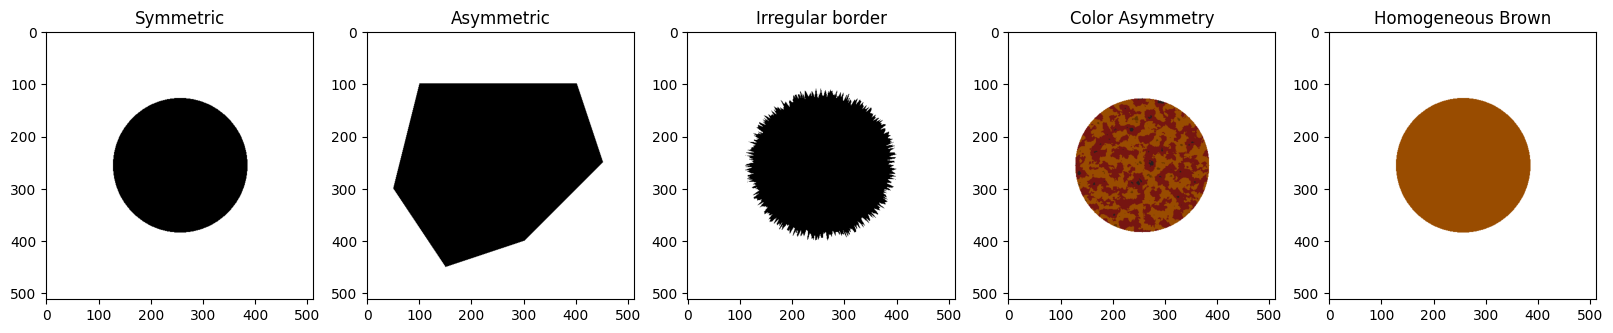

In [20]:
# Create a blank 512x512 image with a white background
width, height = 512, 512
symmetric_img = Image.new('1', (width, height), 'white')

# Draw a circle in the center of the image
draw = ImageDraw.Draw(symmetric_img)
circle_radius = min(width, height) // 4
circle_center = (width // 2, height // 2)
draw.ellipse((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
              circle_center[0] + circle_radius, circle_center[1] + circle_radius),
             fill='black')


# Create a blank 512x512 image with a white background
width, height = 512, 512
asymmetric_img = Image.new('1', (width, height), 'white')

# Draw an asymmetric polygon on the image
draw = ImageDraw.Draw(asymmetric_img)
polygon_points = [
    (100, 100),
    (400, 100),
    (450, 250),
    (300, 400),
    (150, 450),
    (50, 300)
]
draw.polygon(polygon_points, fill='black')

# Create a blank 512x512 image with a white background
width, height = 512, 512
irregular_img = Image.new('1', (width, height), 'white')

# Draw an irregular circular border on the image
draw = ImageDraw.Draw(irregular_img)
circle_center = (width // 2, height // 2)
radius = min(width, height) // 2 - 120
num_segments = 500
angle_step = 2 * math.pi / num_segments

# Generate points for the irregular border
points = []
for i in range(num_segments):
    angle = i * angle_step
    random_radius_offset = random.uniform(-10, 10)
    x = circle_center[0] + (radius + random_radius_offset) * math.cos(angle)
    y = circle_center[1] + (radius + random_radius_offset) * math.sin(angle)
    points.append((x, y))

# Draw the irregular border figure
draw.polygon(points, fill='black')




# Create a blank 512x512 image with a white background
width, height = 512, 512
colorasymmetry_img = Image.new('RGB', (width, height), 'white')
draw = ImageDraw.Draw(colorasymmetry_img)

# Define colors
colors = [
    (197, 188, 217),  # white
    (41, 31, 30),     # black
    (118, 21, 17),    # red
    (153, 76, 0),     # light brown
    (102, 51, 0),     # dark brown
    (70, 130, 180)    # blue-gray
]

circle_radius = min(width, height) // 4
circle_center = (width // 2, height // 2)

# Parameters for the Perlin noise function
scale = 0.05
octaves = 4
persistence = 0.5
lacunarity = 2.0

for y in range(height):
    for x in range(width):
        # Calculate the distance from the center of the image
        dx = x - circle_center[0]
        dy = y - circle_center[1]
        distance = np.sqrt(dx * dx + dy * dy)

        if distance <= circle_radius:
            # Generate Perlin noise value
            noise_val = pnoise2(x * scale, y * scale, octaves, persistence, lacunarity)

            # Map noise value to a color index
            color_idx = int(((noise_val + 1) / 2) * len(colors)) % len(colors)

            # Set the pixel color
            draw.point((x, y), fill=colors[color_idx])



# Create a blank 512x512 image with a white background
width, height = 512, 512
homogeneous_brown_img = Image.new('RGB', (width, height), 'white')

# Draw a circle in the center of the image with a homogenous brown color
draw = ImageDraw.Draw(homogeneous_brown_img)
circle_radius = min(width, height) // 4
circle_center = (width // 2, height // 2)
brown_color = (153, 76, 0)  # Brown color

draw.pieslice((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
               circle_center[0] + circle_radius, circle_center[1] + circle_radius),
              start=0, end=360, fill=brown_color)


# display all images side by side as Matplotlib figure with title for each image
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
ax[0].imshow(symmetric_img, cmap='gray')
ax[0].set_title('Symmetric')
ax[1].imshow(asymmetric_img, cmap='gray')
ax[1].set_title('Asymmetric')
ax[2].imshow(irregular_img, cmap='gray')
ax[2].set_title('Irregular border')
ax[3].imshow(colorasymmetry_img)
ax[3].set_title('Color Asymmetry')
ax[4].imshow(homogeneous_brown_img)
ax[4].set_title('Homogeneous Brown')
plt.show()

Asymmetry score:

In [21]:
def asymmetry_score(image_path):
    # if image_path is of type Image, then continue, else open the image
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')
    
    width, height = image.size

    # Calculate areas for each half along both axes
    area_top, area_bottom, area_left, area_right = 0, 0, 0, 0
    for y in range(height):
        for x in range(width):
            pixel_value = image.getpixel((x, y))
            if pixel_value == 0:  # Black pixel
                if y < height // 2:
                    area_top += 1
                else:
                    area_bottom += 1

                if x < width // 2:
                    area_left += 1
                else:
                    area_right += 1

    # Calculate the asymmetry scores for both axes
    vertical_asymmetry = abs(area_top - area_bottom) / (area_top + area_bottom)
    horizontal_asymmetry = abs(area_left - area_right) / (area_left + area_right)

    # Calculate the average asymmetry score
    average_asymmetry = (vertical_asymmetry + horizontal_asymmetry) / 2
    return average_asymmetry

# mask_path = 'your_mask_image_path.png'
print("Asymmetry score for Symmetric Image:", asymmetry_score(symmetric_img))
print("Asymmetry score for Asymmetric Image:", asymmetry_score(asymmetric_img))

Asymmetry score for Symmetric Image: 0.004955936517731453
Asymmetry score for Asymmetric Image: 0.09888327467903978


In [22]:
# PAT_93_361_53.png

# sample code to show invert coloring of mask, where white becomes black and black becomes white. 
filename = 'PAT_93_361_53.png'
mask_path = os.path.join('../data/shanon_masks_total', filename)
mask = Image.open(mask_path)

print("Asymmetry score for Asymmetric Image:", asymmetry_score(mask))


Asymmetry score for Asymmetric Image: 0.02571085365042473


Irregular border measurement:

In [23]:
import numpy as np
from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing

def border_irregularity_score(image_path):
    # Load the image and convert to a binary numpy array
    # if image_path is of type Image, then continue, else open the image
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')

    mask = np.array(image)

    # Close small gaps in the mask to get a better contour
    mask_closed = binary_closing(mask)

    # Find contours and take the longest one as the border
    contours = find_contours(mask_closed, 0.5)
    border = max(contours, key=len)

    # Calculate the perimeter of the border
    perimeter = 0
    for i in range(len(border) - 1):
        perimeter += np.linalg.norm(border[i + 1] - border[i])

    # Calculate the area of the mask
    area = np.sum(mask)

    # Calculate the border irregularity score (perimeter-to-area ratio)
    irregularity_score = perimeter / area
    return irregularity_score

print("Border irregularity score / Smooth:", border_irregularity_score(symmetric_img))
print("Border irregularity score / Irregular:", border_irregularity_score(irregular_img))

Border irregularity score / Smooth: 0.0040472901122593306
Border irregularity score / Irregular: 0.010806981394770637


Color irregularity measurement

The image is subdivided into blocks of 3 × 3 pixels. We select only those who have at least 75% of their area inside the lesion. The colour average of each selected block is computed. 
The image with more variance among the blocks has higher score. Make a score from 0 to 6

In [24]:
import numpy as np
from skimage.color import rgb2lab

def color_symmetry(image):
    # Convert image to LAB color space
    lab_image = rgb2lab(image)

    # Get image dimensions
    height, width, _ = image.shape

    # Divide image into 3x3 blocks
    block_size = 3
    num_blocks_x = width // block_size
    num_blocks_y = height // block_size

    # Initialize list to store color averages
    color_avgs = []

    # Loop through each block
    for i in range(num_blocks_x):
        for j in range(num_blocks_y):
            # Get the block from the image
            block = lab_image[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size, :]

            # Check if block is at least 75% inside lesion
            if np.sum(block[:, :, 0] < 90) >= (0.75 * block_size**2):
                # Compute color average for the block
                color_avg = np.mean(block, axis=(0, 1))
                color_avgs.append(color_avg)

    # Compute variance of color averages
    variances = np.var(color_avgs, axis=0)
    variance_score = np.mean(variances)
    
    # Clip variance score between 0 and 100
    variance_score = np.clip(variance_score, 0, 100)

    # Map the score to a scale from 0 to 6
    score = round(6 * variance_score / 100)

    return score

In [25]:
# Convert images to numpy arrays
homogeneous_brown_arr = np.array(homogeneous_brown_img)
colorasymmetry_arr = np.array(colorasymmetry_img)

# Call the color_symmetry function with the numpy arrays
print('Symmetric image:', color_symmetry(homogeneous_brown_arr))
print('Asymmetric image:', color_symmetry(colorasymmetry_arr))

Symmetric image: 0
Asymmetric image: 4


Now, to skin lesion images

Load masked image

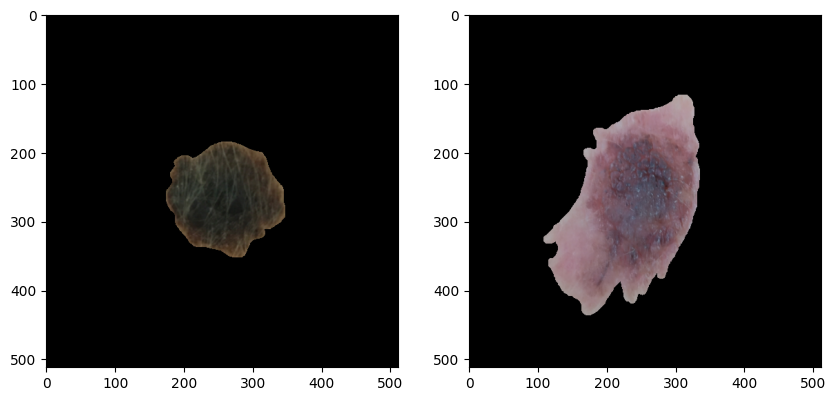

In [26]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def load_masked_image(image_path, mask_path):
    # read image in BGR
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    masked_image = cv2.bitwise_and(image, image, mask=mask) # apply mask to image
    return masked_image

image_path = '..\\data\\shanon_training\\PAT_710_1330_243.PNG'
mask_path = '..\\data\\shanon_masks_groundtruth\\PAT_710_1330_243.PNG'
masked_image = load_masked_image(image_path, mask_path)

image_path1 = '..\\data\\shanon_training\\PAT_975_1834_152.PNG'
mask_path1 = '..\\data\\shanon_masks_groundtruth\\PAT_975_1834_152.PNG'
masked_image1 = load_masked_image(image_path1, mask_path1)

# display
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.subplot(1, 2, 2)
plt.imshow(masked_image1)
plt.show()

In [27]:
masked_image_arr = np.array(masked_image)
masked_image1_arr = np.array(masked_image1)

print('Symmetric image:', color_symmetry(masked_image_arr))
print('Asymmetric image:', color_symmetry(masked_image1_arr))

Symmetric image: 1
Asymmetric image: 6


Assessment of algorithmic measurements vs. manual measurements for 5 samples as proof of concept

Manuual measurement of 5 skin lesions is stored in ../data/manual_measurement.csv

In [28]:
filename = '../data/manual_measurement.csv'

with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip the header row
    data = []
    for row in reader:
        data.append(row[:4])

print(data)

[['PAT_340_714_314.png', '2', '6', '4'], ['PAT_627_1188_503.png', '0', '2', '2.5'], ['PAT_710_1330_243.png', '1', '2', '1'], ['PAT_801_1518_574.png', '1', '4', '3'], ['PAT_975_1834_152.png', '2', '5', '5']]


append algo_asymmetric score to data:

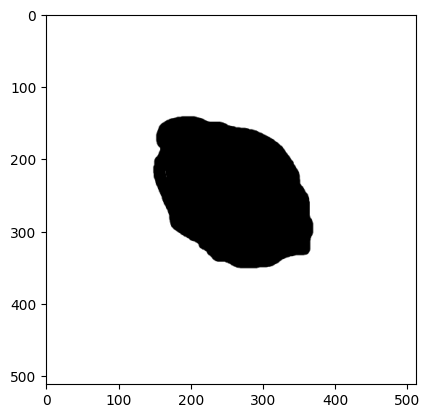

In [29]:
# sample code to show invert coloring of mask, where white becomes black and black becomes white. 
filename = 'PAT_627_1188_503.png'
mask_path = os.path.join('../data/Manual_feature_masks', filename)
mask = Image.open(mask_path)
mask_inverted = ImageOps.invert(mask)

# display flipped mask
plt.imshow(mask_inverted, cmap='gray')

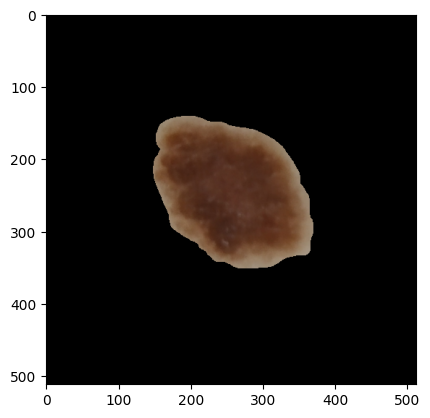

In [30]:
# sample code for loading masked image:
filename = 'PAT_627_1188_503.png'
image_path = os.path.join('../data/Manual_feature_images', filename)
mask_path = os.path.join('../data/Manual_feature_masks', filename)
masked_image = load_masked_image(image_path, mask_path)
# display image
plt.imshow(masked_image)

In [31]:
for i in data:
    filename = i[0]
    image_path = os.path.join('../data/Manual_feature_images', filename)
    mask_path = os.path.join('../data/Manual_feature_masks', filename)
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    mask_inverted = ImageOps.invert(mask)
    
    # calc asymmetry
    asymmetry = asymmetry_score(mask)
    # calc border irregularity
    border_irregularity = border_irregularity_score(mask_inverted)
    # calc color asymmetry
    masked_image = load_masked_image(image_path, mask_path)
    masked_image_arr = np.array(masked_image)
    color_asymmetry = color_symmetry(masked_image)
    
    # append these scores to data for this row
    i.append(asymmetry)
    i.append(border_irregularity)
    i.append(color_asymmetry)

for i in data:
    print(i)

['PAT_340_714_314.png', '2', '6', '4', 0.039889902226604226, 0.008971265483439825, 4]
['PAT_627_1188_503.png', '0', '2', '2.5', 0.009711299941943315, 0.0033949502878729476, 4]
['PAT_710_1330_243.png', '1', '2', '1', 0.01077798672841296, 0.0024461762668463974, 1]
['PAT_801_1518_574.png', '1', '4', '3', 0.006957549659088511, 0.0037298512560259797, 2]
['PAT_975_1834_152.png', '2', '5', '5', 0.04738405783770856, 0.0049532805779638304, 6]


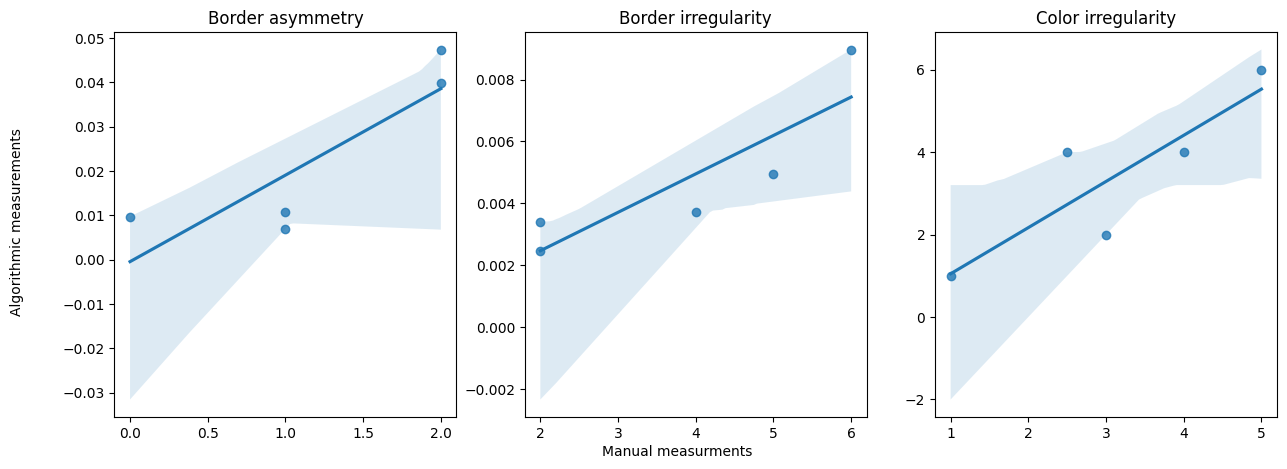

In [32]:
# extract data from columns
col1 = [float(row[1]) for row in data]
col2 = [float(row[2]) for row in data]
col3 = [float(row[3]) for row in data]
col4 = [float(row[4]) for row in data]
col5 = [float(row[5]) for row in data]
col6 = [float(row[6]) for row in data]

# Create subplots for each pair of columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Set common axis labels
fig.text(0.5, 0.04, 'Manual measurments', ha='center', va='center')
fig.text(0.06, 0.5, 'Algorithmic measurements', ha='center', va='center', rotation='vertical')

# Plot scatter plot and regression line for each pair of columns
sns.regplot(x=col1, y=col4, ax=axs[0])
sns.regplot(x=col2, y=col5, ax=axs[1])
sns.regplot(x=col3, y=col6, ax=axs[2])

# Set subplot titles
axs[0].set_title('Border asymmetry')
axs[1].set_title('Border irregularity')
axs[2].set_title('Color irregularity')

plt.show()

Algorithmically extract (1) Border Asymmetry Score, (2) Irregular Border Score, (3) Color Irregularity Score 
from all images where my have labeled masks

Create a CSV file with all the features

In [33]:
filename = 'MEL_ids.csv'

# Extract the IDs from the CSV file
mel_ids = []
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        mel_ids.append(row[0])

# Write the IDs to a new CSV file with a 'diagnosis' column
with open('features_output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_id', 'diagnosis'])
    for mel_id in mel_ids:
        writer.writerow([mel_id, 'MEL'])

filename_sek = 'SEK_ids.csv'
sek_ids = []
with open(filename_sek, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # Skip the header row
    for row in reader:
        sek_ids.append(row[0])

with open('features_output.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for sek_id in sek_ids:
        writer.writerow([sek_id, 'SEK'])

add asymmetry, border_irregularity, color_irregularity to features_output.csv
In addition, add selected features from metadata.csv to features_output.csv

In [34]:
with open('features_output.csv', 'r+', newline='') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)
    header.append('asymmetry')
    header.append('border_irregularity')
    header.append('color_asymmetry')
    header.append('diameter_avg')
    header.append('smoke')
    header.append('age')
    header.append('itch')

    rows = []
    for row in reader:
        rows.append(row)
        
    for i, row in enumerate(rows):
        # if image does not exist, then continue
        if not os.path.exists(os.path.join('../data/images_resized', row[0])):
            continue
        image_path = os.path.join('../data/images_resized', row[0])
        mask_path = os.path.join('../data/shanon_masks_total', row[0])
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        mask_inverted = ImageOps.invert(mask)
        
        # calc asymmetry
        asymmetry = asymmetry_score(mask)
        # calc border irregularity
        border_irregularity = border_irregularity_score(mask_inverted)
        # calc color asymmetry
        masked_image = load_masked_image(image_path, mask_path)
        masked_image_arr = np.array(masked_image)
        color_asymmetry = color_symmetry(masked_image)
        
        rows[i].append(asymmetry)
        rows[i].append(border_irregularity)
        rows[i].append(color_asymmetry)

        with open('../data/metadata.csv', newline='') as metafile:
            meta_reader = csv.reader(metafile)
            next(meta_reader)  # Skip the header row
            for meta_row in meta_reader:
                if meta_row[24] == row[0]:
                    # Append new values to the row
                    diameter_avg = (float(meta_row[15]) + float(meta_row[16])) / 2
                    rows[i].append(diameter_avg)
                    rows[i].append(meta_row[2])
                    rows[i].append(meta_row[6])
                    rows[i].append(meta_row[18])
                    break  # Stop searching after finding a match

    # Write the updated rows to the file
    csvfile.seek(0)  # Rewind the file pointer
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for row in rows:
        writer.writerow(row)